In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Memuat dataset
df = pd.read_csv('/content/BigBasket Dataset.csv')
df.head()


,Member,Order,SKU,Created On,Description
0,M09736,6468572.0,34993740.0,41904.94792,Other Sauces
1,M09736,6468572.0,15669800.0,41904.94792,Cashews
2,M09736,6468572.0,15669800.0,41904.94792,Cashews
3,M09736,6468572.0,15669800.0,41904.94792,Cashews
4,M09736,6468572.0,15669800.0,41904.94792,Cashews


In [14]:
# Memeriksa kolom yang relevan
df = df[['Member', 'Created On', 'Order']]  # Pilih kolom yang relevan
df['Created On'] = pd.to_datetime(df['Created On'], errors='coerce')  # Mengubah 'Created On' menjadi format tanggal
df.head()


/tmp/ipython-input-2110150057.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created On'] = pd.to_datetime(df['Created On'], errors='coerce')  # Mengubah 'Created On' menjadi format tanggal


,Member,Created On,Order
0,M09736,NaT,6468572.0
1,M09736,NaT,6468572.0
2,M09736,NaT,6468572.0
3,M09736,NaT,6468572.0
4,M09736,NaT,6468572.0


In [15]:
# Menentukan tanggal saat ini
current_date = df['Created On'].max() + pd.DateOffset(1)  # Menggunakan tanggal terakhir dalam dataset + 1 hari

# Recency (R)
recency_df = df.groupby('Member').agg({
    'Created On': lambda x: (current_date - x.max()).days  # Selisih hari antara tanggal transaksi terakhir dan hari ini
}).reset_index()
recency_df.rename(columns={'Created On': 'Recency'}, inplace=True)

# Frequency (F)
frequency_df = df.groupby('Member').agg({
    'Order': 'count'  # Menghitung jumlah transaksi
}).reset_index()
frequency_df.rename(columns={'Order': 'Frequency'}, inplace=True)

# Monetary (M)
monetary_df = df.groupby('Member').agg({
    'Order': 'sum'  # Total pengeluaran per pelanggan, misalnya jumlah pembelian
}).reset_index()
monetary_df.rename(columns={'Order': 'Monetary'}, inplace=True)

# Menggabungkan RFM
rfm_df = recency_df.merge(frequency_df, on='Member').merge(monetary_df, on='Member')
rfm_df.head()


,Member,Recency,Frequency,Monetary
0,M04158,96.0,12737,9.879684e+10
1,M08075,1.0,29566,2.267168e+11
2,M09303,1.0,9349,6.961398e+10
3,M09736,27.0,31180,2.376516e+11
4,M12050,5.0,23320,1.755750e+11


In [16]:
# Menentukan segmentasi RFM
def rfm_segment(row):
    if row['Recency'] <= 30 and row['Frequency'] >= 10 and row['Monetary'] >= 100:
        return 'Champion'
    elif row['Recency'] <= 60 and row['Frequency'] >= 5 and row['Monetary'] >= 50:
        return 'Loyal'
    elif row['Recency'] > 60 and row['Frequency'] <= 5 and row['Monetary'] <= 20:
        return 'At Risk'
    elif row['Recency'] > 90 and row['Frequency'] <= 2 and row['Monetary'] <= 10:
        return 'New'
    else:
        return 'Other'

# Apply function
rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

rfm_df.head()


,Member,Recency,Frequency,Monetary,Segment
0,M04158,96.0,12737,9.879684e+10,Other
1,M08075,1.0,29566,2.267168e+11,Champion
2,M09303,1.0,9349,6.961398e+10,Champion
3,M09736,27.0,31180,2.376516e+11,Champion
4,M12050,5.0,23320,1.755750e+11,Champion


/tmp/ipython-input-3285448268.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Segment', palette='Set2')


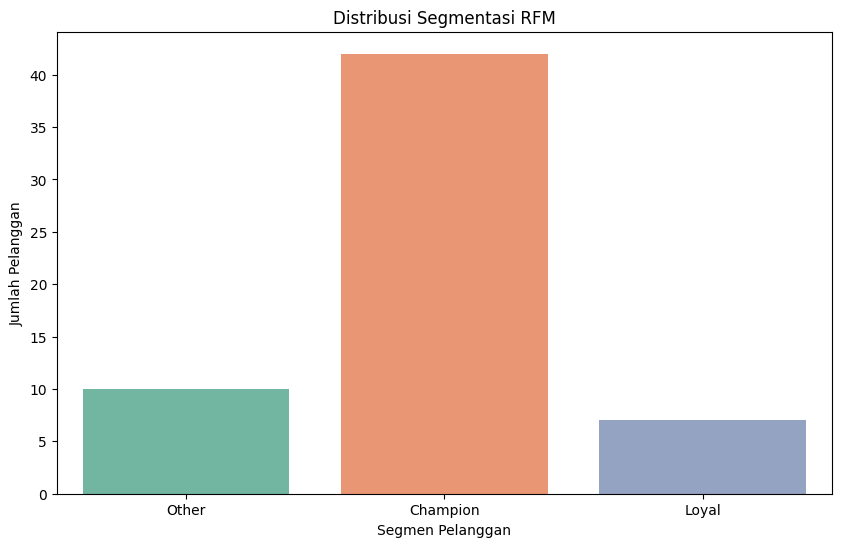

In [17]:
# Visualisasi Segmentasi Pelanggan
plt.figure(figsize=(10,6))
sns.countplot(data=rfm_df, x='Segment', palette='Set2')
plt.title('Distribusi Segmentasi RFM')
plt.xlabel('Segmen Pelanggan')
plt.ylabel('Jumlah Pelanggan')
plt.show()


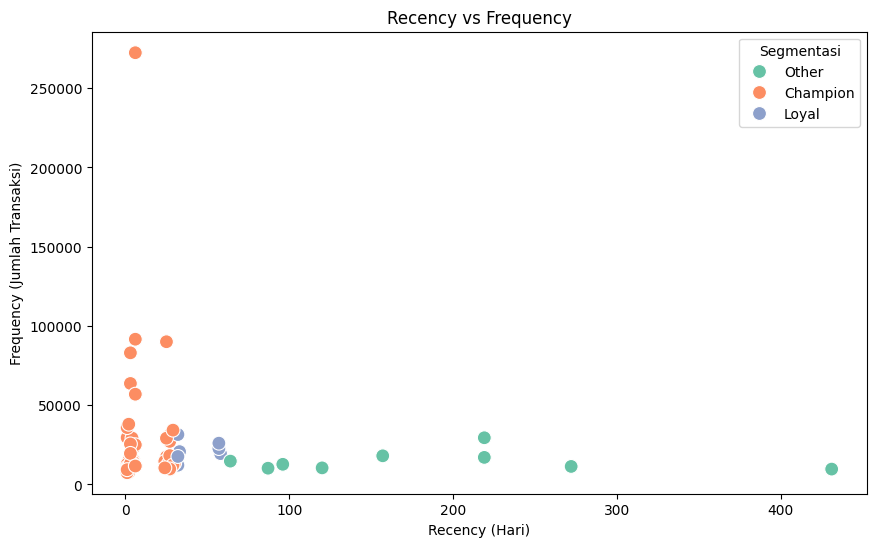

In [18]:
# Visualisasi Recency vs Frequency
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Segment', palette='Set2', s=100)
plt.title('Recency vs Frequency')
plt.xlabel('Recency (Hari)')
plt.ylabel('Frequency (Jumlah Transaksi)')
plt.legend(title='Segmentasi', loc='upper right')
plt.show()


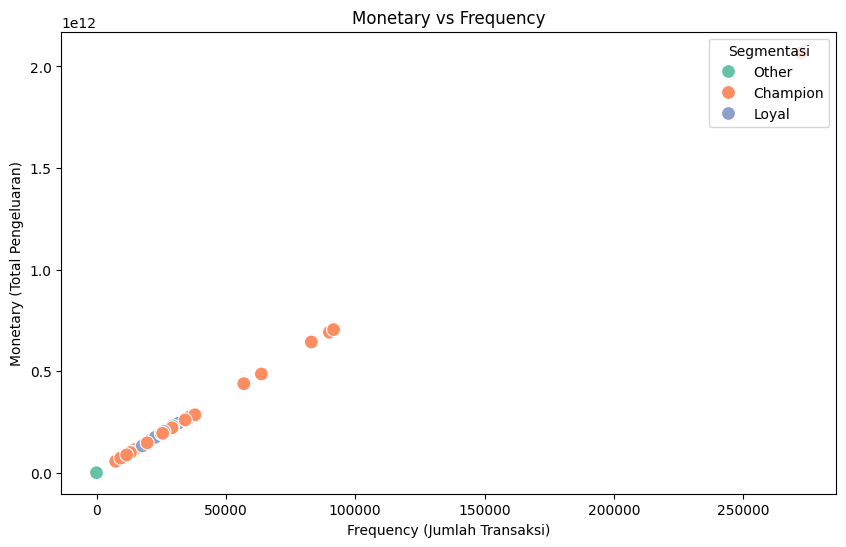

In [19]:
# Visualisasi Monetary vs Frequency
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Segment', palette='Set2', s=100)
plt.title('Monetary vs Frequency')
plt.xlabel('Frequency (Jumlah Transaksi)')
plt.ylabel('Monetary (Total Pengeluaran)')
plt.legend(title='Segmentasi', loc='upper right')
plt.show()


In [20]:
# Menyimpan hasil RFM ke CSV di direktori saat ini
rfm_df.to_csv('rfm_result.csv', index=False)


In [21]:
from google.colab import files

# Mengunduh file CSV ke komputer lokal
files.download('rfm_result.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
rfm_df.to_csv('rfm_result.csv', index=False)


In [23]:
from google.colab import files
files.download('rfm_result.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [25]:
# Load the dataset (gantilah dengan path file Anda)
rfm_data = pd.read_csv('rfm_result.csv')

In [26]:
# Pilih fitur yang digunakan untuk clustering
rfm_features = rfm_data[['Recency', 'Frequency', 'Monetary']]

In [27]:
# Standarisasi data agar skala fitur seragam
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

In [30]:
rfm_data_cleaned = rfm_data.dropna()  # Drop rows with any missing values

In [34]:
# Select only the numeric columns for cleaning
rfm_data_numeric = rfm_data[['Recency', 'Frequency', 'Monetary']]

# Fill NaN values in the numeric columns with the mean of each column
rfm_data_numeric_filled = rfm_data_numeric.fillna(rfm_data_numeric.mean())

# Standardize the cleaned data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data_numeric_filled)

# Apply KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# Check the results
print(rfm_data[['Recency', 'Frequency', 'Monetary', 'KMeans_Cluster']].head())


   Recency  Frequency      Monetary  KMeans_Cluster
0     96.0      12737  9.879684e+10               1
1      1.0      29566  2.267168e+11               1
2      1.0       9349  6.961398e+10               1
3     27.0      31180  2.376516e+11               1
4      5.0      23320  1.755750e+11               1


In [35]:
# Terapkan KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

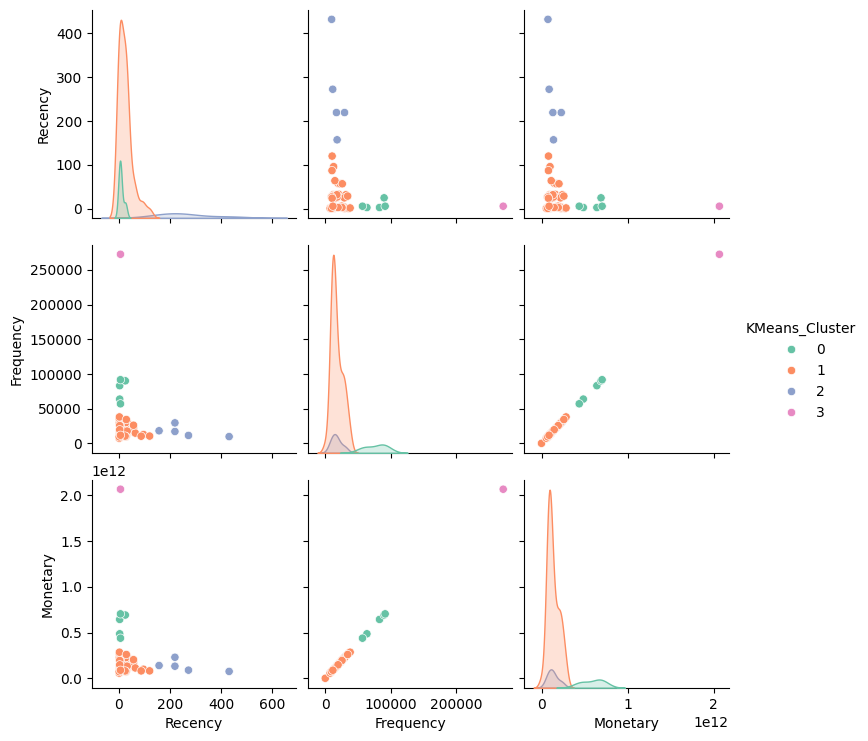

In [36]:
# Visualisasikan hasil clustering dengan pairplot
sns.pairplot(rfm_data, hue='KMeans_Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='Set2')
plt.show()

In [37]:
# Bandingkan hasil segmentasi dengan hasil KMeans
comparison = rfm_data[['Segment', 'KMeans_Cluster']].drop_duplicates()
print(comparison)

     Segment  KMeans_Cluster
0      Other               1
1   Champion               1
5      Other               2
7      Loyal               1
16  Champion               0
39  Champion               3
